In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from telepyth import TelepythClient
tp = TelepythClient()

Use token from .telepythrc.


In [2]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(24)
print(mkl_get_max_threads())

16
24


In [3]:
from sklearn.svm import SVR

In [4]:
from quffka.dataset import make_dataset
from quffka.kernels import arccos0_kernel, arccos1_kernel
from quffka.performance import get_scores
from quffka.visualize import plot_errors

## Settings

In [5]:
N = 2
runs = 2
exact = {}
acc_d = {}

In [ ]:
params = [1, N, runs, 0, 1, None, None]  # for plotting purposes

In [6]:
kernels = ['RBF', 'Arccos 0', 'Arccos 1']
approx_types = ['G', 'Gort', 'ROM', 'QMC', 'GQ', 'B']
datasets = ['Powerplant', 'LETTER', 'USPS']
scores = {d:{k:{a:np.zeros((N, runs)) for a in approx_types} for k in kernels} for d in datasets}

In [7]:
scores['USPS']['RBF']['Gort']

array([[0., 0.],
       [0., 0.]])

# Powerplant

In [8]:
dataset_name = 'Powerplant'

## compute scores with exact kernels

In [9]:
def get_exact_scores(dataset_name):
    dataset, _ = make_dataset(dataset_name)
    xtrain, ytrain, xtest, ytest = dataset
    
    clf_rbf = SVR()
    clf_rbf.fit(xtrain, ytrain)
    exact_rbf = clf_rbf.score(xtest, ytest)

    clf_arccos1 = SVR(kernel=arccos1_kernel)
    clf_arccos1.fit(xtrain, ytrain)
    exact_arccos1 = clf_arccos1.score(xtest, ytest)

    clf_arccos0 = SVR(kernel=arccos0_kernel)
    clf_arccos0.fit(xtrain, ytrain)
    exact_arccos0 = clf_arccos0.score(xtest, ytest)
    return exact_rbf, exact_arccos0, exact_arccos1

In [18]:
exact[dataset_name] = get_exact_scores(dataset_name)

## compute scores with approximated kernels

In [10]:
%%time
%%telepyth
for i in tnrange(len(approx_types)):
    get_scores(dataset_name, kernels, approx_types[i], SVR, N, runs, scores)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


CPU times: user 16min 54s, sys: 43.7 s, total: 17min 38s
Wall time: 2min 37s


In [11]:
scores['Powerplant']['Arccos 0']['G']

array([[0.80214283, 0.82789098],
       [0.8347224 , 0.83192275]])

# LETTER

In [13]:
dataset_name = 'LETTER'
exact[dataset_name] = get_exact_scores(dataset_name)

In [14]:
%%time
%%telepyth
for i in tnrange(len(approx_types)):
    get_scores(dataset_name, kernels, approx_types[i], SVR, N, runs, scores)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


CPU times: user 25min 26s, sys: 1min 26s, total: 26min 53s
Wall time: 4min 17s


In [15]:
scores['LETTER']['Arccos 0']['G']

array([[0.17340815, 0.17738766],
       [0.17699719, 0.20017735]])

# USPS

In [ ]:
dataset_name = 'USPS'
exact[dataset_name] = get_exact_scores(dataset_name)

In [ ]:
%%time
%%telepyth
for i in tnrange(len(approx_types)):
    get_scores(dataset_name, kernels, approx_types[i], SVR, N, runs, scores)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [ ]:
scores['LETTER']['Arccos 0']['G']

# Plot downstream task performance

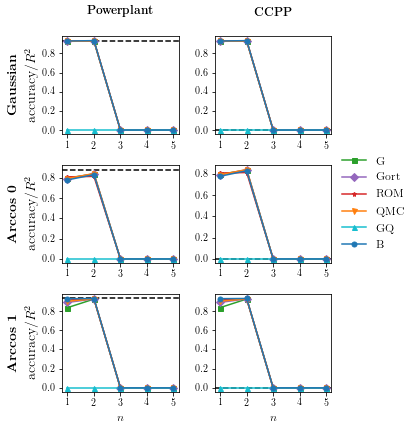

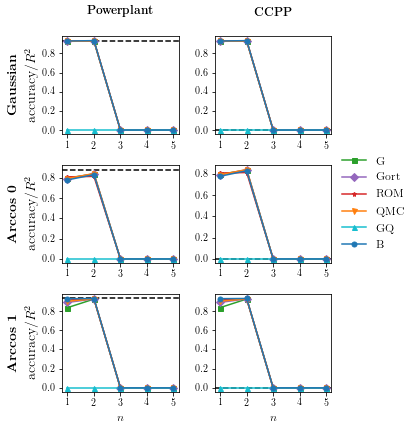

In [39]:
plot_errors(errs_d, datasets, kernels, approx_types, False, True, exact)

In [38]:
def plot_errors(errs_dic, datasets, kernels, approx_types, semilogy=False,
                acc=False, exact=None, params=None):
    m = len(datasets)
    n = len(kernels)
    fig, axes = plt.subplots(ncols=m, nrows=n, figsize=(w*m, h))

    if acc:
        ylabel = r'accuracy/$R^2$'
    else:
        ylabel = r'$\frac{\|K - \hat{K}\|}{\|K\|}$'

    for l, dataset_name in enumerate(datasets):
        errs_d = errs_dic[dataset_name]
        if params is None:
                params = PARAMS[dataset_name]
        start_deg, max_deg, _, shift, step, _, _ = params

        x = np.arange(start_deg, max_deg + step, step) + shift
        for k, kernel in enumerate(kernels):
            errs = errs_d[kernel]
            formatter = LogFormatterMathtext()
            formatterx = ScalarFormatter(useMathText=True, useOffset=False)
            formatterx.set_powerlimits((-1,1))
            axes[k, l].xaxis.set_major_locator(MaxNLocator(integer=True))
            axes[k, l].yaxis.set_major_locator(MaxNLocator(6))

            ci = np.empty((max_deg, 2))
            m = np.zeros(max_deg)
            if acc:
                axes[k, l].axhline(exact[dataset_name][kernel], linestyle='--',
                                   label=r'\textbf{exact}', color='black')
            for a in approx_types:
                if a in errs:
                    er = errs[a]
                else:
                    continue
                ma = MARKERS[a]
                color = set_color(a)
                for j in range(er.shape[0]):
                    m[j], ci[j, 0], ci[j, 1] = \
                        mean_confidence_interval(er[j,:])
                if semilogy:
                    axes[k, l].yaxis.set_major_formatter(formatter)
                    axes[k, l].semilogy(x, m, '.-', label=r'\textbf{%s}' % a,
                                        color=color, marker=ma, markersize=5)
                    axes[k, l].fill_between(x, np.maximum(0, ci[:, 0]),
                                            ci[:, 1], alpha=0.3, color=color)
                else:
                    axes[k, l].yaxis.set_major_formatter(formatterx)
                    axes[k, l].plot(x, m, '.-', label=r'\textbf{%s}' % a,
                                    color=color, marker=ma, markersize=5)
                    axes[k, l].fill_between(x, np.maximum(0, ci[:, 0]),
                                            ci[:, 1], alpha=0.3, color=color)
            # last row gets x labels
            if k == n - 1:
                axes[k, l].set_xlabel(r'$n$', fontsize=basefontsize)
            # first column gets y labels
            if l == 0:
                axes[k, l].set_ylabel(ylabel, fontsize=bigfontsize)
                if kernel == 'RBF':
                    kernel_ = 'Gaussian'
                else:
                    kernel_ = kernel
                axes[k, l].annotate(r'\textbf{%s}' % kernel_, [0.,0.5],
                                    xytext=(-axes[k, l].yaxis.labelpad, 0),
                                    xycoords=axes[k, l].yaxis.label,
                                    textcoords='offset points',
                                    fontsize=bigfontsize, ha='right',
                                    va='center', rotation=90)
            # first row gets title
            if k == 0:
                title = r'\textbf{%s}' % dataset_name
                axes[k, l].set_title(title, fontsize=basefontsize,
                                     y=title_h[semilogy])
    # authentic organic hand-made legend!
    patches = []
    for a in approx_types:
        patches.append(mlines.Line2D([], [], color=set_color(a),
                                     marker=MARKERS[a], markersize=5,
                                     label=a))
    plt.legend(bbox_to_anchor=(1.05, legend_h[semilogy]),
               loc=2, borderaxespad=0., framealpha=0.0,
               fontsize=basefontsize, handles=patches)
    # makes plot look nice
    fig.tight_layout()
    fig.subplots_adjust(left=left[semilogy], top=top[semilogy],
                        right=right[semilogy])
    plt.show()
    return fig
